In [1]:
# import relevant modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [2]:
transactions_m = pd.read_csv('data/merged_data.csv', usecols=['client_id', 'transaction_id', 'target', 'date', 'merchant_state', 'amount'])

In [3]:
fraud_users = transactions_m.loc[transactions_m['target']==1, 'client_id']

In [4]:
fraud_users.value_counts()

client_id
1102    58
209     52
27      45
155     44
1128    43
        ..
380      1
1696     1
37       1
1427     1
1817     1
Name: count, Length: 1196, dtype: int64

In [5]:
user_id = 1102

In [39]:
user_transactions = transactions_m.loc[transactions_m['client_id'] == user_id, :]

In [41]:
user_transactions[['transaction_id']].to_csv('transactions.csv')

In [42]:
input_data_path = 'data/'
transactions = pd.read_csv(f'{input_data_path}/model_data_1102.csv')

In [43]:
transactions = transactions.set_index('transaction_id')

In [45]:
X = transactions.loc[transactions.index.isin(user_transactions['transaction_id'])].drop('target', axis=1)
y = transactions.loc[transactions.index.isin(user_transactions['transaction_id']), 'target']
seed = 42

In [49]:
# create function to calculate model metrics
def model_metrics(conf_matrix):
    '''
    Calculate model metrics (PCC,error rates, precision, sensitvity, and specificity

    Args:
    tn: True negatives
    fp: False positives
    fn: False negatives
    tp: True positives
    cutoff: The cutoff value of the model being evaluated; default is 0.5

    Returns:
    Dictionary of model metrics
    '''

    tn=conf_matrix[0][0]
    fp= conf_matrix[0][1]
    fn=conf_matrix[1][0]
    tp=conf_matrix[1][1]
    
    metrics = {}
    metrics['pcc'] = (tn + tp) / (tn + fp + fn + tp)
    metrics['false_alarm_rate'] = fp / (tn + fp)
    metrics['false_dismissal_rate'] = fn / (fn + tp)
    metrics['precision'] = tp / (tp + fp)
    metrics['sensitivity'] = tp / (tp + fn)
    metrics['specificity'] = tn / (tn + fp)
    print(f"""
          The PCC is {metrics['pcc']:.4f}\n
          The false alarm rate is {metrics['false_alarm_rate']:.4f}\n
          The false dismissal rate is {metrics['false_dismissal_rate']:.4f}\n
          The precision is {metrics['precision']:.4f}\n
          The sensitivity is {metrics['sensitivity']:.4f} and\n
          The specificity is {metrics['specificity']:.4f}""")
    return metrics

In [50]:
if_model = IsolationForest(random_state=seed)
if_preds = if_model.fit_predict(X)
if_preds[if_preds == 1] = 0
if_preds[if_preds == -1] = 1
print(classification_report(y, if_preds))
print(confusion_matrix(y, if_preds))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     11832
         1.0       0.14      0.55      0.22        58

    accuracy                           0.98     11890
   macro avg       0.57      0.77      0.61     11890
weighted avg       0.99      0.98      0.99     11890

[[11636   196]
 [   26    32]]


In [51]:
model_metrics(confusion_matrix(y, if_preds))


          The PCC is 0.9813

          The false alarm rate is 0.0166

          The false dismissal rate is 0.4483

          The precision is 0.1404

          The sensitivity is 0.5517 and

          The specificity is 0.9834


{'pcc': 0.9813288477712363,
 'false_alarm_rate': 0.01656524678837052,
 'false_dismissal_rate': 0.4482758620689655,
 'precision': 0.14035087719298245,
 'sensitivity': 0.5517241379310345,
 'specificity': 0.9834347532116294}

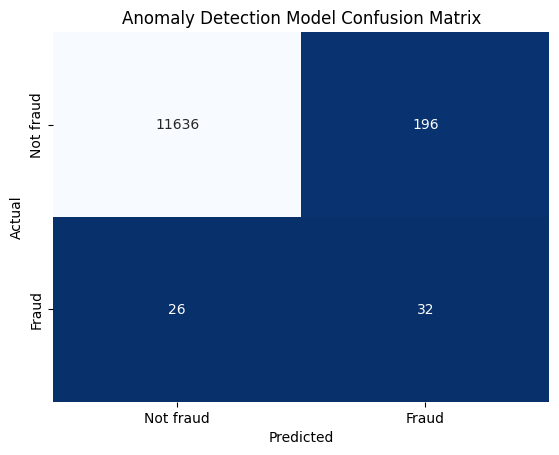

In [213]:
labels = ['Not fraud', 'Fraud']
sns.heatmap(confusion_matrix(y, if_preds), annot=True, fmt="d", cmap='Blues_r', cbar=False, 
xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Anomaly Detection Model Confusion Matrix')
plt.savefig('Anomaly detection', dpi=600)
plt.show()


In [53]:
lof_model = LocalOutlierFactor(n_neighbors=30)
lof_preds = lof_model.fit_predict(X)
lof_preds_scores = -1 * lof_model.negative_outlier_factor_
lof_preds[lof_preds == 1] = 0
lof_preds[lof_preds == -1] = 1
print(classification_report(y, lof_preds))
print(confusion_matrix(y, lof_preds))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     11832
         1.0       0.13      0.57      0.21        58

    accuracy                           0.98     11890
   macro avg       0.56      0.78      0.60     11890
weighted avg       0.99      0.98      0.99     11890

[[11612   220]
 [   25    33]]


In [54]:
model_metrics(confusion_matrix(y, lof_preds))


          The PCC is 0.9794

          The false alarm rate is 0.0186

          The false dismissal rate is 0.4310

          The precision is 0.1304

          The sensitivity is 0.5690 and

          The specificity is 0.9814


{'pcc': 0.979394449116905,
 'false_alarm_rate': 0.01859364435429344,
 'false_dismissal_rate': 0.43103448275862066,
 'precision': 0.13043478260869565,
 'sensitivity': 0.5689655172413793,
 'specificity': 0.9814063556457066}

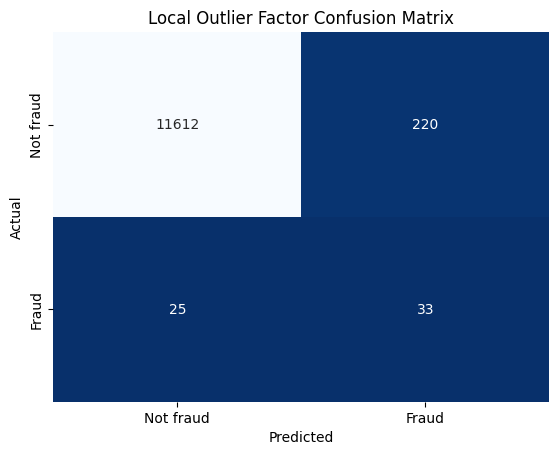

In [ ]:
labels = ['Not fraud', 'Fraud']
sns.heatmap(confusion_matrix(y, lof_preds), annot=True, fmt="d", cmap='Blues_r', cbar=False, 
xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Local Outlier Factor Confusion Matrix')
plt.savefig('')
plt.show()


In [56]:
import joblib
model = joblib.load('models/decision_tree.pkl')

In [72]:
for col in X.columns:
    if 'category' in col:
        new_col = col.replace('_ ', ', ')
        X = X.rename(columns={col:new_col})

In [75]:
X = X.rename(columns={'category_Betting _including Lottery Tickets, Casinos_': 'category_Betting (including Lottery Tickets, Casinos)',
                      'category_Drinking Places _Alcoholic Beverages_': 'category_Drinking Places (Alcoholic Beverages)'})

In [76]:
dt_preds = model.predict(X)

In [77]:
print(classification_report(y, dt_preds))
print(confusion_matrix(y, dt_preds))

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98     11832
         1.0       0.10      0.90      0.17        58

    accuracy                           0.96     11890
   macro avg       0.55      0.93      0.58     11890
weighted avg       1.00      0.96      0.97     11890

[[11337   495]
 [    6    52]]


In [78]:
model_metrics(confusion_matrix(y, dt_preds))


          The PCC is 0.9579

          The false alarm rate is 0.0418

          The false dismissal rate is 0.1034

          The precision is 0.0951

          The sensitivity is 0.8966 and

          The specificity is 0.9582


{'pcc': 0.9578637510513036,
 'false_alarm_rate': 0.041835699797160245,
 'false_dismissal_rate': 0.10344827586206896,
 'precision': 0.09506398537477148,
 'sensitivity': 0.896551724137931,
 'specificity': 0.9581643002028397}

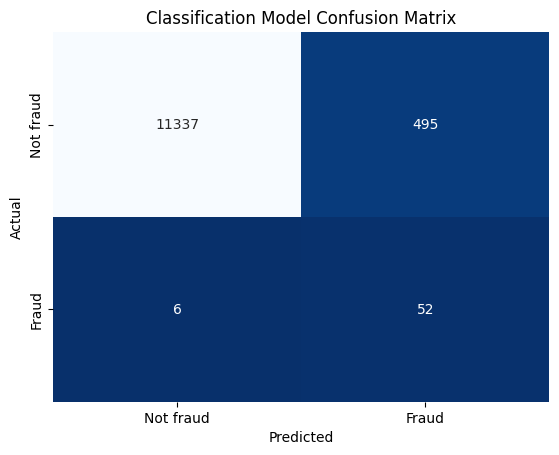

In [214]:
labels = ['Not fraud', 'Fraud']
sns.heatmap(confusion_matrix(y, dt_preds), annot=True, fmt="d", cmap='Blues_r', cbar=False, 
xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Classification Model Confusion Matrix')
plt.savefig('dt', dpi=600)
plt.show()


In [80]:
propensities = model.predict_proba(X)[:, 1]

In [81]:
abs(user_transactions['amount']).describe()

count    11890.000000
mean        70.570271
std        115.122469
min          0.350000
25%         13.600000
50%         22.765000
75%        107.587500
max       1589.540000
Name: amount, dtype: float64

In [82]:
70.570271 + (3*115.122469)

415.93767799999995

In [83]:
user_transactions['date'] = pd.to_datetime(user_transactions['date'])

In [84]:
user_transactions = user_transactions.sort_values(by=['client_id', 'date'])

# Calculate time difference (in seconds) between consecutive transactions for each client
user_transactions['time_diff'] = user_transactions.groupby('client_id')['date'].diff().dt.total_seconds()

In [85]:
count = 0
counts = []

for diff in user_transactions['time_diff']:
    if diff <= 3600:  # If the previous transaction happened within 1 hour, increment count
        count += 1
    else:  # Otherwise, reset count
        count = 0
    counts.append(count)

In [ ]:
# Ensure 'date' column is in datetime format
#user_transactions['date'] = pd.to_datetime(user_transactions['date'])

# Create a new column for unusual locations by counting unique states per client_id
#user_transactions['unusual_location_count'] = user_transactions.groupby('client_id')['merchant_state'].transform(lambda x: len(x.unique()))

# Sort by client and date
#user_transactions = user_transactions.sort_values(by=['client_id', 'date'])

# Calculate time difference (in seconds) between consecutive transactions for each client
#user_transactions['time_diff'] = user_transactions.groupby('client_id')['date'].diff().dt.total_seconds()

# Count the number of transactions within the last hour (3600 seconds)
user_transactions['transactions_last_hour'] = counts

# Extract the hour from the 'date' column
user_transactions['hour'] = user_transactions['date'].dt.hour

# Count night transactions (transactions between 1 AM and 4 AM)
user_transactions['night_trans_count'] = user_transactions['hour'].between(1, 4).astype(int)

# Rule 1: High amount and international transaction
user_transactions['rule_1'] = (user_transactions['amount'] > 415.94) & (user_transactions['merchant_state'] != 'United States')

# Rule 2: Unusual location (≥2 different states)
user_transactions['rule_2'] = user_transactions['merchant_state'] != 'United States'

# Rule 3: High-velocity transactions (≥10 in last hour)
user_transactions['rule_3'] = user_transactions['transactions_last_hour'] >= 10

# Rule 4: Extreme amount (>$999)
user_transactions['rule_4'] = user_transactions['amount'] > 415.94

# Rule 5: Night transactions (1AM-4AM)
user_transactions['rule_5'] = user_transactions['night_trans_count'] >= 5

# Compute total rule score
user_transactions['rule_score'] = user_transactions[['rule_1', 'rule_2', 'rule_3', 'rule_4', 'rule_5']].sum(axis=1)

# Apply decisions with severity logic
user_transactions['decision'] = np.select(
    [user_transactions['rule_score'] >= 3,  user_transactions['rule_score'] == 2,  user_transactions['rule_score'] == 1], # Low severity transactions
    ['Block', 'Manual Review', 'Flag'],  # Corrected decision application
    default='Allow'  # If none of the above, the transaction is allowed
)

# Now you can check the resulting dataframe to verify the decisions
print(user_transactions[['client_id', 'amount', 'merchant_state', 'rule_1', 'rule_2', 'rule_3', 'rule_4', 'rule_5', 'rule_score', 'decision']].head())

      client_id  amount merchant_state  rule_1  rule_2  rule_3  rule_4  \
335        1102    4.42  United States   False   False   False   False   
698        1102   79.86  United States   False   False   False   False   
730        1102  -59.00  United States   False   False   False   False   
1365       1102  106.83  United States   False   False   False   False   
2567       1102    3.36  United States   False   False   False   False   

      rule_5  rule_score decision  
335    False           0    Allow  
698    False           0    Allow  
730    False           0    Allow  
1365   False           0    Allow  
2567   False           0    Allow  


In [190]:
user_transactions.decision.value_counts()

decision
Allow    11025
Flag       800
Block       65
Name: count, dtype: int64

In [200]:
r_preds = np.select(
    [user_transactions['rule_score'] >= 1], # Low severity transactions
    [1],  # Corrected decision application
    default=0  # If none of the above, the transaction is allowed
)


In [201]:
print(classification_report(y, r_preds))
print(confusion_matrix(y, r_preds))

              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96     11832
         1.0       0.00      0.07      0.01        58

    accuracy                           0.92     11890
   macro avg       0.50      0.50      0.48     11890
weighted avg       0.99      0.92      0.96     11890

[[10971   861]
 [   54     4]]


In [202]:
model_metrics(confusion_matrix(y, r_preds))


          The PCC is 0.9230

          The false alarm rate is 0.0728

          The false dismissal rate is 0.9310

          The precision is 0.0046

          The sensitivity is 0.0690 and

          The specificity is 0.9272


{'pcc': 0.9230445752733389,
 'false_alarm_rate': 0.07276876267748479,
 'false_dismissal_rate': 0.9310344827586207,
 'precision': 0.004624277456647399,
 'sensitivity': 0.06896551724137931,
 'specificity': 0.9272312373225152}

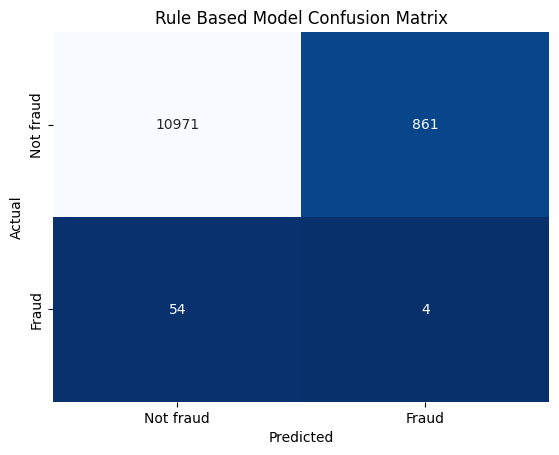

In [212]:
labels = ['Not fraud', 'Fraud']
sns.heatmap(confusion_matrix(y, r_preds), annot=True, fmt="d", cmap='Blues_r', cbar=False, 
xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Rule Based Model Confusion Matrix')
plt.savefig('rbm', dpi=600)
plt.show()


In [102]:
thresholds = pd.DataFrame({'propensities':propensities, 'actual':y, 'dt_pred_at_05':dt_preds, 'if_pred':if_preds,
                           'lof_pred':lof_preds, 'rbm_pred':r_preds})

In [103]:
thresholds['dt_pred_at_08'] = np.where(thresholds['propensities'] >= 0.8, 1, 0)

In [104]:
thresholds.head()

,propensities,actual,dt_pred_at_05,if_pred,lof_pred,rbm_pred,dt_pred_at_08
transaction_id,,,,,,,
17008474,0.135418,0.0,0.0,0,0,0,0
19743479,0.000000,0.0,0.0,0,0,0,0
8183364,0.000000,0.0,0.0,0,0,0,0
21073614,0.000000,0.0,0.0,0,0,0,0
22480303,0.000000,0.0,0.0,0,0,0,0


In [133]:
thresholds['score1'] = thresholds['rbm_pred']+thresholds['if_pred']+thresholds['dt_pred_at_08']

In [145]:
thresholds.head()

,propensities,actual,dt_pred_at_05,if_pred,lof_pred,rbm_pred,dt_pred_at_08,score1
transaction_id,,,,,,,,
17008474,0.135418,0.0,0.0,0,0,0,0,0
19743479,0.000000,0.0,0.0,0,0,0,0,0
8183364,0.000000,0.0,0.0,0,0,0,0,0
21073614,0.000000,0.0,0.0,0,0,0,0,0
22480303,0.000000,0.0,0.0,0,0,0,0,0


In [159]:
thresholds.score1.value_counts()

score1
0    10511
1     1190
2      182
3        7
Name: count, dtype: int64

In [205]:
preds = np.select(
    [thresholds['score1']>1],
    [1],
    default=0
)

In [180]:
conf_mat_08 = confusion_matrix(y, preds)

In [206]:
conf_mat_08

array([[10506,  1326],
       [    5,    53]], dtype=int64)

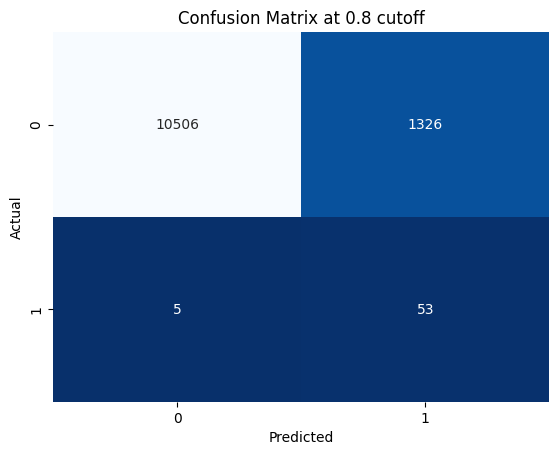

In [207]:
# show the confusion matrix in a heat map
sns.heatmap(conf_mat_08, annot=True, fmt="d", cmap='Blues_r', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix at 0.8 cutoff')
plt.show()

In [208]:
print(classification_report(y, preds))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     11832
         1.0       0.17      0.57      0.27        58

    accuracy                           0.98     11890
   macro avg       0.59      0.78      0.63     11890
weighted avg       0.99      0.98      0.99     11890



In [184]:
model_metrics(confusion_matrix(y, preds))


          The PCC is 0.8881

          The false alarm rate is 0.1121

          The false dismissal rate is 0.0862

          The precision is 0.0384

          The sensitivity is 0.9138 and

          The specificity is 0.8879


{'pcc': 0.8880571909167367,
 'false_alarm_rate': 0.11206896551724138,
 'false_dismissal_rate': 0.08620689655172414,
 'precision': 0.03843364757070341,
 'sensitivity': 0.9137931034482759,
 'specificity': 0.8879310344827587}